### 리그오브레전드 시계열 게임 데이터 기반 승패예측 모델 개발

리그오브레전드 API를 이용한 데이터 추출을 진행하여 분석을 진행하였습니다. 현재 코드에는 관련 API 사용 코드는 제공하고 있지 않습니다. 관련 내용은 리그오브레전드 공식 API 사이트를 이용하시기 바랍니다. 현재 코드는 리그오브레전드 데이터를 기반으로, 최종적으로 사용한 모델 방식인 플레이어별 모델 구축 및 아웃풋을 결합한 방식만 담겨 있으며, 데이터만(columns 변수 참조, 각 경기별 20분 동안의 다음과 같은 데이터 사용) 생성하실 경우, 실행이 가능합니다. 

In [ ]:
import pandas as pd
import numpy as np
import random
from tqdm.notebook import tqdm 
import matplotlib.pyplot as plt

from scipy import stats
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

import tensorflow as tf
from tensorflow.python.ops import rnn, rnn_cell
from tensorflow import keras
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.models import Model

In [ ]:
#승혁형 그랜드마스터 경기 Blue팀 데이터 4615개
data3 =  pd.read_csv("138games.csv",header = 0)

#형준형 Blue팀 데이터
# data1 = pd.read_csv("ch_1_blue.csv",header = 0)
# data1 = data1.rename(columns = {'participantId_5_win': 'win'})
# 보류

#승혁형 Blue팀 데이터
# data2 = pd.read_csv("Riot_924games_team1.csv",header = 0)
# data2.win = data2.win.str.replace('Fail', '0').replace('Win', '1').astype('int')

In [ ]:
#형준형 데이터 20분 interval씩만 가져오기
# for i in set(data1['gameid']):
#     print(len(data1[data1['gameid'] == i]))

#컬럼 삭제
# del data3['Unnamed: 0']
# del data['team']

In [ ]:
# def generate_data(X, sequence_length = 20, step = 20):
#     X_local = pd.DataFrame()
#     for start in range(0, len(X) - sequence_length, step):
#         end = start + sequence_length
#         X_local = pd.concat( [X_local, X[start:end]] , axis=0) #append(X[start:end])
#     return X_local

In [ ]:
data3.columns

Index(['top_x', 'top_y', 'top_totalGold', 'top_level', 'top_xp',
       'top_minionsKilled', 'top_jungleMinionsKilled', 'top_split',
       'top_companion', 'top_rotation', 'jungle_x', 'jungle_y',
       'jungle_totalGold', 'jungle_level', 'jungle_xp', 'jungle_minionsKilled',
       'jungle_jungleMinionsKilled', 'jungle_split', 'jungle_companion',
       'jungle_rotation', 'mid_x', 'mid_y', 'mid_totalGold', 'mid_level',
       'mid_xp', 'mid_minionsKilled', 'mid_jungleMinionsKilled', 'mid_split',
       'mid_companion', 'mid_rotation', 'ad_x', 'ad_y', 'ad_totalGold',
       'ad_level', 'ad_xp', 'ad_minionsKilled', 'ad_jungleMinionsKilled',
       'ad_split', 'ad_companion', 'ad_rotation', 'support_x', 'support_y',
       'support_totalGold', 'support_level', 'support_xp',
       'support_minionsKilled', 'support_jungleMinionsKilled', 'support_split',
       'support_companion', 'support_rotation', 'win'],
      dtype='object')

In [ ]:
#일부 원하는 컬럼을 결정하여 데이터 사용
columns = ['top_x', 'top_y', 'top_totalGold', 'top_level', 'top_xp',
       'top_minionsKilled', 'top_jungleMinionsKilled', 'top_split',
       'top_companion', 'jungle_x', 'jungle_y',
       'jungle_totalGold', 'jungle_level', 'jungle_xp', 'jungle_minionsKilled',
       'jungle_jungleMinionsKilled', 'jungle_split', 'jungle_companion',
       'mid_x', 'mid_y', 'mid_totalGold', 'mid_level',
       'mid_xp', 'mid_minionsKilled', 'mid_jungleMinionsKilled', 'mid_split',
       'mid_companion', 'ad_x', 'ad_y', 'ad_totalGold',
       'ad_level', 'ad_xp', 'ad_minionsKilled', 'ad_jungleMinionsKilled',
       'ad_split', 'ad_companion', 'support_x', 'support_y',
       'support_totalGold', 'support_level', 'support_xp',
       'support_minionsKilled', 'support_jungleMinionsKilled', 'support_split',
       'support_companion',  'win']

data3 = data3[columns]

In [ ]:
#데이터 형식 확인
data3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2760 entries, 0 to 2759
Data columns (total 51 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   top_x                        2760 non-null   int64  
 1   top_y                        2760 non-null   int64  
 2   top_totalGold                2760 non-null   int64  
 3   top_level                    2760 non-null   int64  
 4   top_xp                       2760 non-null   int64  
 5   top_minionsKilled            2760 non-null   int64  
 6   top_jungleMinionsKilled      2760 non-null   int64  
 7   top_split                    2760 non-null   float64
 8   top_companion                2760 non-null   float64
 9   top_rotation                 2760 non-null   float64
 10  jungle_x                     2760 non-null   int64  
 11  jungle_y                     2760 non-null   int64  
 12  jungle_totalGold             2760 non-null   int64  
 13  jungle_level      

In [ ]:
data3['win'].value_counts()

0    1400
1    1360
Name: win, dtype: int64

In [ ]:
#독립변수들에 MinMaxScaler 적용
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
scaler.fit(data3.loc[:,'top_x':'top_rotation'])

MinMaxScaler(copy=True, feature_range=(0, 1))

In [ ]:
#플레이어별 데이터 분리 및 scaler 적용
# scaler.fit(all_data.loc[:,'participantId_1_x':'participantId_1_xp'])
p1d2 = scaler.transform(data3.loc[:,'top_x':'top_rotation'])

# scaler.fit(all_data.loc[:,'participantId_2_x':'participantId_2_xp'])
p2d2 = scaler.transform(data3.loc[:,'jungle_x':'jungle_rotation'])

# scaler.fit(all_data.loc[:,'participantId_3_x':'participantId_3_xp'])
p3d2 = scaler.transform(data3.loc[:,'mid_x':'mid_rotation'])

# scaler.fit(all_data.loc[:,'participantId_4_x':'participantId_4_xp'])
p4d2 = scaler.transform(data3.loc[:,'ad_x':'ad_rotation'])

# scaler.fit(all_data.loc[:,'participantId_5_x':'participantId_5_xp'])
p5d2 = scaler.transform(data3.loc[:,'support_x':'support_rotation'])

In [ ]:
wd2 = data3['win']

In [ ]:
#인풋데이터 형태 갖추기위한 함수(플레이어별 게임당 20행 25열 - 20개 타임라인, 25개 컬럼 데이터)
def generate_data_X(X, sequence_length = 20, step = 20):
    X_local = []
    for start in range(0, len(X) - sequence_length, step):
        end = start + sequence_length
        X_local.append(X[start:end])
    return np.array(X_local)

def generate_data_y(y, sequence_length = 20, step = 20):
    y_local = []
    for start in range(0, len(y) - sequence_length, step):
        end = start + sequence_length
        y_local.append(y[end-1])
    return np.array(y_local)

In [ ]:
#인풋데이터 형태 갖추기위한 함수(플레이어별 게임당 20행 25열 - 20개 타임라인, 25개 컬럼 데이터)
def generate_data_X(X, sequence_length = 20, step = 20):
    X_local = []
    for start in range(0, len(X), step):
        end = start + sequence_length
        X_local.append(X[start:end])
    return np.array(X_local)

def generate_data_y(y, sequence_length = 20, step = 20):
    y_local = []
    for start in range(0, len(y), step):
        end = start + sequence_length
        y_local.append(y[end-1])
    return np.array(y_local)

In [ ]:
#플레이어별 인풋데이터 제작
p1d = generate_data_X(p1d2)
p2d = generate_data_X(p2d2)
p3d = generate_data_X(p3d2)
p4d = generate_data_X(p4d2)
p5d = generate_data_X(p5d2)
wd = generate_data_y(wd2)

---------------------------------0---------------------------------
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
p1 (InputLayer)                 [(None, 20, 10)]     0                                            
__________________________________________________________________________________________________
p2 (InputLayer)                 [(None, 20, 10)]     0                                            
__________________________________________________________________________________________________
p3 (InputLayer)                 [(None, 20, 10)]     0                                            
__________________________________________________________________________________________________
p4 (InputLayer)                 [(None, 20, 10)]     0                                            
__________________________

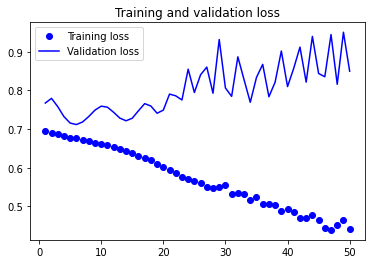

2/2 [==============================] - 0s 15ms/step - loss: 0.8500 - binary_accuracy: 0.6098
[0.8499513864517212, 0.6097561120986938]
---------------------------------1---------------------------------
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
p1 (InputLayer)                 [(None, 20, 10)]     0                                            
__________________________________________________________________________________________________
p2 (InputLayer)                 [(None, 20, 10)]     0                                            
__________________________________________________________________________________________________
p3 (InputLayer)                 [(None, 20, 10)]     0                                            
________________________________________________________________________________________

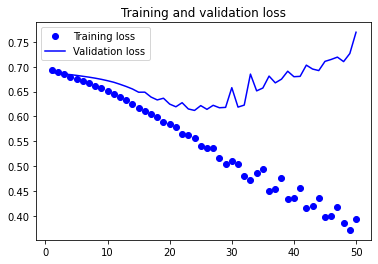

2/2 [==============================] - 0s 17ms/step - loss: 0.7692 - binary_accuracy: 0.6098
[0.7691671848297119, 0.6097561120986938]
---------------------------------2---------------------------------
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
p1 (InputLayer)                 [(None, 20, 10)]     0                                            
__________________________________________________________________________________________________
p2 (InputLayer)                 [(None, 20, 10)]     0                                            
__________________________________________________________________________________________________
p3 (InputLayer)                 [(None, 20, 10)]     0                                            
________________________________________________________________________________________

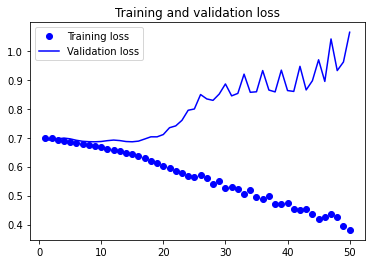

2/2 [==============================] - 0s 15ms/step - loss: 1.0642 - binary_accuracy: 0.5610
[1.0642412900924683, 0.5609756112098694]
---------------------------------3---------------------------------
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
p1 (InputLayer)                 [(None, 20, 10)]     0                                            
__________________________________________________________________________________________________
p2 (InputLayer)                 [(None, 20, 10)]     0                                            
__________________________________________________________________________________________________
p3 (InputLayer)                 [(None, 20, 10)]     0                                            
________________________________________________________________________________________

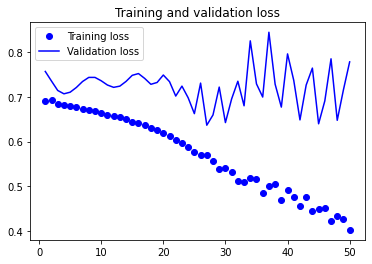

2/2 [==============================] - 0s 13ms/step - loss: 0.7780 - binary_accuracy: 0.5366
[0.7779759764671326, 0.5365853905677795]
---------------------------------4---------------------------------
Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
p1 (InputLayer)                 [(None, 20, 10)]     0                                            
__________________________________________________________________________________________________
p2 (InputLayer)                 [(None, 20, 10)]     0                                            
__________________________________________________________________________________________________
p3 (InputLayer)                 [(None, 20, 10)]     0                                            
________________________________________________________________________________________

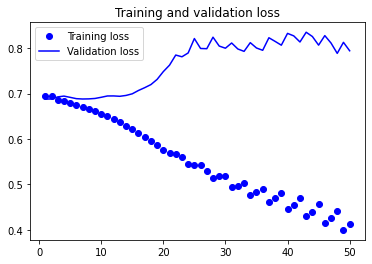

2/2 [==============================] - 0s 21ms/step - loss: 0.7942 - binary_accuracy: 0.6585
[0.7941569089889526, 0.6585366129875183]
---------------------------------5---------------------------------
Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
p1 (InputLayer)                 [(None, 20, 10)]     0                                            
__________________________________________________________________________________________________
p2 (InputLayer)                 [(None, 20, 10)]     0                                            
__________________________________________________________________________________________________
p3 (InputLayer)                 [(None, 20, 10)]     0                                            
________________________________________________________________________________________

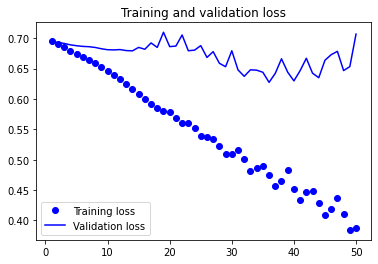

2/2 [==============================] - 0s 17ms/step - loss: 0.7067 - binary_accuracy: 0.6585
[0.7067182660102844, 0.6585366129875183]
---------------------------------6---------------------------------
Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
p1 (InputLayer)                 [(None, 20, 10)]     0                                            
__________________________________________________________________________________________________
p2 (InputLayer)                 [(None, 20, 10)]     0                                            
__________________________________________________________________________________________________
p3 (InputLayer)                 [(None, 20, 10)]     0                                            
________________________________________________________________________________________

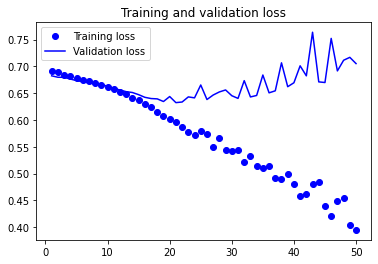

2/2 [==============================] - 0s 21ms/step - loss: 0.7051 - binary_accuracy: 0.6341
[0.7051286101341248, 0.6341463327407837]
---------------------------------7---------------------------------
Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
p1 (InputLayer)                 [(None, 20, 10)]     0                                            
__________________________________________________________________________________________________
p2 (InputLayer)                 [(None, 20, 10)]     0                                            
__________________________________________________________________________________________________
p3 (InputLayer)                 [(None, 20, 10)]     0                                            
________________________________________________________________________________________

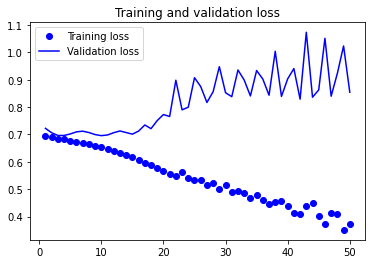

2/2 [==============================] - 0s 17ms/step - loss: 0.8544 - binary_accuracy: 0.6341
[0.854360044002533, 0.6341463327407837]
---------------------------------8---------------------------------
Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
p1 (InputLayer)                 [(None, 20, 10)]     0                                            
__________________________________________________________________________________________________
p2 (InputLayer)                 [(None, 20, 10)]     0                                            
__________________________________________________________________________________________________
p3 (InputLayer)                 [(None, 20, 10)]     0                                            
_________________________________________________________________________________________

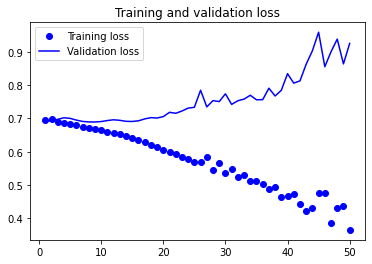

2/2 [==============================] - 0s 21ms/step - loss: 0.9254 - binary_accuracy: 0.5610
[0.9254395365715027, 0.5609756112098694]
---------------------------------9---------------------------------
Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
p1 (InputLayer)                 [(None, 20, 10)]     0                                            
__________________________________________________________________________________________________
p2 (InputLayer)                 [(None, 20, 10)]     0                                            
__________________________________________________________________________________________________
p3 (InputLayer)                 [(None, 20, 10)]     0                                            
________________________________________________________________________________________

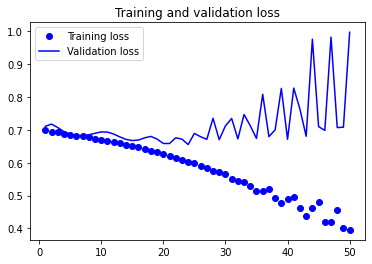

2/2 [==============================] - 0s 20ms/step - loss: 0.9968 - binary_accuracy: 0.5122
[0.9968129396438599, 0.5121951103210449]


In [ ]:
#최종모델 설계
score=[]
for i in range(10):
    print('---------------------------------' + str(i) + '---------------------------------' )
    np.random.seed(i)
    all_num = list(range(len(p1d)))
    train_num = list(np.random.choice(all_num, size= (round(len(p1d)*0.7)), replace=False))
    test_num = all_num.copy()
    for i in train_num:
        test_num.remove(i)

    p1d_train = p1d[train_num,:]
    p1d_test = p1d[test_num,:]
    p2d_train = p2d[train_num,:]
    p2d_test = p2d[test_num,:]
    p3d_train = p3d[train_num,:]
    p3d_test = p3d[test_num,:]
    p4d_train = p4d[train_num,:]
    p4d_test = p4d[test_num,:]
    p5d_train = p5d[train_num,:]
    p5d_test = p5d[test_num,:]
    wd_train = wd[train_num]
    wd_test = wd[test_num]



    #플레이어별 LSTM 모델 생성
    p1 = tf.keras.Input(shape=(20,10),name='p1')
    p2 = tf.keras.Input(shape=(20,10),name='p2')
    p3 = tf.keras.Input(shape=(20,10),name='p3')
    p4 = tf.keras.Input(shape=(20,10),name='p4')
    p5 = tf.keras.Input(shape=(20,10),name='p5')

    p1Layers = LSTM(100,return_sequences=False)(p1)#,dropout=0.1, recurrent_dropout=0.1)(p1)
    p2Layers = LSTM(100,return_sequences=False)(p2)#,dropout=0.1, recurrent_dropout=0.1)(p2)
    p3Layers = LSTM(100,return_sequences=False)(p3)#,dropout=0.1, recurrent_dropout=0.1)(p3)
    p4Layers = LSTM(100,return_sequences=False)(p4)#,dropout=0.1, recurrent_dropout=0.1)(p4)
    p5Layers = LSTM(100,return_sequences=False)(p5)#,dropout=0.1, recurrent_dropout=0.1)(p5)

    output = tf.keras.layers.concatenate(inputs=[p1Layers, p2Layers, p3Layers,p4Layers,p5Layers],axis=1)
    output = Dense(1,activation='sigmoid')(output)
    model = Model(inputs=[p1, p2, p3, p4, p5],outputs=[output])
    model.compile(loss="binary_crossentropy", metrics=[keras.metrics.binary_accuracy], optimizer="adam")
    model.summary()


    #모델 학습
    history = model.fit([p1d_train, p2d_train, p3d_train, p4d_train, p5d_train],wd_train,validation_data = ([p1d_test, p2d_test, p3d_test, p4d_test, p5d_test], wd_test),epochs = 50,batch_size=300)


    #그래프 생성
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

    #성능 평가 및 출력
    score.append(model.evaluate([p1d_test, p2d_test, p3d_test, p4d_test, p5d_test], wd_test))
    print( model.evaluate([p1d_test, p2d_test, p3d_test, p4d_test, p5d_test], wd_test) )

In [ ]:
score

[[0.8499513864517212, 0.6097561120986938],
 [0.7691671848297119, 0.6097561120986938],
 [1.0642412900924683, 0.5609756112098694],
 [0.7779759764671326, 0.5365853905677795],
 [0.7941569089889526, 0.6585366129875183],
 [0.7067182660102844, 0.6585366129875183],
 [0.7051286101341248, 0.6341463327407837],
 [0.854360044002533, 0.6341463327407837],
 [0.9254395365715027, 0.5609756112098694],
 [0.9968129396438599, 0.5121951103210449]]

In [ ]:
val_score = []
for i in score:
  val_score.append(i[1])

In [ ]:
np.mean(val_score)

0.5975609838962554

------------